To enable interactive plots, run `jupyter labextension install jupyter-matplotlib` followed by:

In [1]:
!pip install --upgrade ipympl matplotlib -q
%matplotlib ipympl

In [17]:
!pip install hdbscan pymatgen colorcet -q

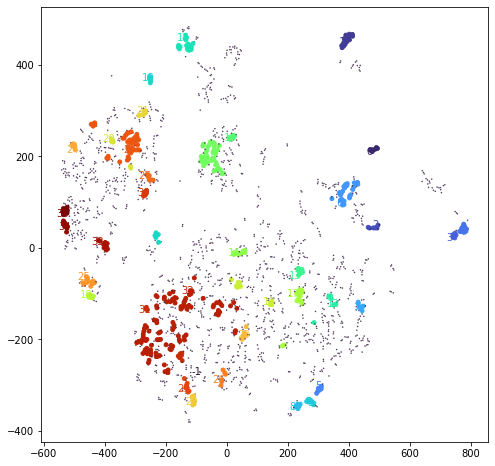

In [14]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
sys.path.append('../autoencoder')
# sys.path.append('/notebooks/Beta-VAE/')
# from models import*

from src.band_plotters import*
from src.TensorImageNoised import *
from src.cluster_plotters import *
sys.path.append('/notebooks/band-fingerprint/autoencoder/')
sys.path.append('/notebooks/band-fingerprint/src')

from model import *
import model as resnet_autoencoder

from ae_misc import *

%matplotlib inline

# Enter Full Fingerprint Name - Specify Configuration Below
Note perplexity can be change for second tsne run - see configuration. See `fingerprints` folder to view possible `FINGERPRINT_NAME`'s.

In [31]:
FINGERPRINT_NAME = "224_2channel_resnet_L=98_perplexity_30_length_98"
# FINGERPRINT_NAME = "all_k_branches_histogram_-8_to_8_perplexity_30_length_60"

# Functions to View Materials/Clusters

In [ ]:
def show_image_mpl(tensor)

For any fingerprint

In [100]:
def view_material_any(index, show_inp=False):
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0, fp_dict["length"], fp_dict["length"]), df.loc[index][fingerprint_cols])
    ax.set_xlabel(index)
    ax.set_title("fingerprint")
    plt.show()
    
    if show_inp:
        image = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        image.show()

For an autoencoder based fingerprint

In [134]:
def show_tensor_image(tensor, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(tensor.permute(1, 2,0).detach().numpy(), vmax=1, vmin=0)
    return ax

def view_material_ae_2_channel(index, inp_recon_together=False):
    view_material_any(index)
        
    print(df.loc[index]["member_strength"])

    image_filename = DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png"

    # Get input and prediction
    _, out, _ = learn.predict(image_filename)


    # 2 channel image
    dl = learn.dls.test_dl([image_filename])

    with torch.no_grad():
        inp = dl.one_batch()[0]
        fingerprint_2_channel = learn.model.encoder(inp)

    fingerprint_2_channel = fingerprint_2_channel[0]
    fingerprint_2_channel /= 3.982462167739868 # max activation in fingerprint array
    rgb_image = torch.stack([fingerprint_2_channel[0, :, :], torch.zeros_like(fingerprint_2_channel[0, :, :]), fingerprint_2_channel[1, :, :]], dim=0)
    show_tensor_image(rgb_image)
    
    ax = None
    if inp_recon_together:
        fig, ax = plt.subplots(2, 1)
    
    show_tensor_image(inp[0], ax)
    show_tensor_image(torch.sigmoid(out), ax)
    plt.show()


In [135]:
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(200))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        view_material_function(index)

# Fingerprint Configurations

In [136]:
FINGERPRINTS = {
    "224_2channel_resnet_L=98_perplexity_30_length_98":{
    "hdbscan":{"min_cluster_size":6, "min_samples":2},
    "tsne":{"perplexity":10, "early_exaggeration":12.0},
    "length":98,
    "model": "../autoencoder/trained_models/resnet18_size224_lossbce_channels2.pkl",
    "view_func":view_material_ae_2_channel
    },
    
    "all_k_branches_histogram_-8_to_8_perplexity_30_length_60":{
    "hdbscan":{"min_cluster_size":6, "min_samples":2},
    "tsne":{"perplexity":10, "early_exaggeration":12.0},
    "length":60,
    "model":False,
    "view_func":lambda mat_id: view_material_any(mat_id, True) 
    }
    
}

fp_dict = FINGERPRINTS[FINGERPRINT_NAME]
hdbscan_dict = fp_dict["hdbscan"]
tsne_dict = fp_dict["tsne"]
length = fp_dict["length"]
view_material_function = fp_dict["view_func"]


FLAT_ONLY = True
BORING_COLUMNS = ["flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = FINGERPRINT_NAME + ".csv"

In [137]:
if fp_dict["model"]:
    learn = load_learner(fp_dict["model"])

# Load Data

In [138]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,90,91,92,93,94,95,96,97,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,...,2.325100,1.733577,1.816098,1.953408,1.904952,1.718350,1.920829,1.940830,-17.031164,-22.583645
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,...,2.226489,2.289640,2.589102,2.477097,2.594307,2.217409,2.636327,2.281451,-85.320190,19.231680
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,...,2.502424,1.772349,1.775590,1.941162,1.745729,1.716548,1.714002,1.817789,74.049220,-91.258260
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,...,2.372130,2.224227,2.399812,2.197275,2.769758,2.584419,2.809708,2.114330,36.688946,55.726463
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,...,2.852715,2.168420,2.470804,2.357963,2.278249,2.280239,2.296243,2.235125,11.995536,-106.832634


# Cluster

In [88]:
fingerprint_cols = [str(i) for i in range(length)]
BORING_COLUMNS += fingerprint_cols

In [140]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=0.8, approx_min_span_tree=True,\
gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=hdbscan_dict["min_cluster_size"], min_samples=hdbscan_dict["min_samples"], p=0.2)

clusterer.fit(df[fingerprint_cols])


df["labels"] = clusterer.labels_
df["member_strength"] = clusterer.probabilities_


# View Clusters

In [141]:
%matplotlib inline


interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

interactive(children=(IntSlider(value=23, description='label', max=47, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

# Run TSNE and plot (with draggable labels)

In [142]:
if FLAT_ONLY:
    tsne = manifold.TSNE(n_components=2, early_exaggeration=tsne_dict["early_exaggeration"], init="pca",learning_rate="auto", random_state=0, perplexity=tsne_dict["perplexity"],n_iter=10000, verbose=2, metric="minkowski")
    fingerprint_2d = tsne.fit_transform(df[fingerprint_cols])
    df.fx, df.fy = fingerprint_2d[:, 0], fingerprint_2d[:, 1]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 1.019422
[t-SNE] Computed conditional probabilities in 0.016s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 74.6053696, gradient norm = 0.0123159 (50 iterations in 0.352s)
[t-SNE] Iteration 100: error = 75.4825821, gradient norm = 0.0099334 (50 iterations in 0.351s)
[t-SNE] Iteration 150: error = 76.0996246, gradient norm = 0.0045396 (50 iterations in 1.183s)
[t-SNE] Iteration 200: error = 76.4148178, gradient norm = 0.0026537 (50 iterations in 1.110s)
[t-SNE] Iteration 250: error = 76.4638901, gradient norm = 0.0028607 (50 iterations in 1.043s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.463890
[t-SNE] Iteration 300: error = 2.3112350, gradient norm = 0.0024505 (50 iterations in 1.087s)
[t-SNE] Iteration 350: error = 1.8639212, gradient norm = 0.0010709 (50 iterations in 1.146s)
[t-SNE] Iteration 400: error = 1.6555761, gradient norm = 0.0006331 (50 iterations in 1.145s)
[t-SNE] Iteration 450: error = 1.5371760, gradient norm = 0.0004404 (50 iterations in 1.123s)
[t-SNE] Iteration 500: error = 1.4631188, gradient norm = 0.0003249 (50 

/tmp/ipykernel_503/1740458782.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')


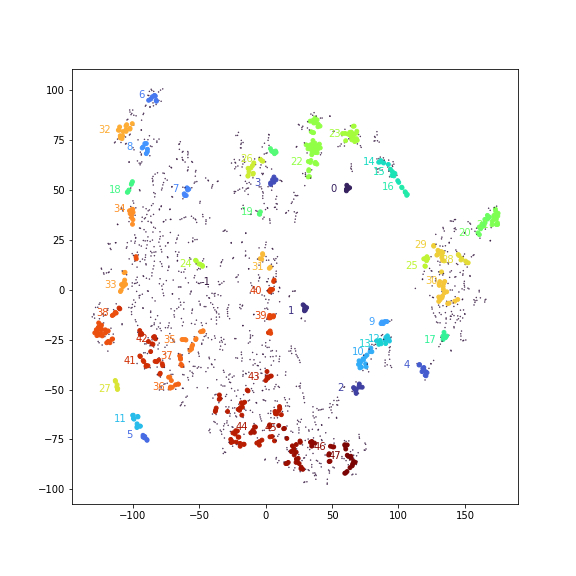

In [143]:
%matplotlib ipympl
labels = clusterer.labels_

fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*15
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprint_2d[rep_id,:]+[-10,0],color=col,alpha=1, weight='normal', ha='center', va='center', size=10).draggable()

plt.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")


plt.show()



In [30]:
plt.savefig("resnet_2_channel_L=96_tsne.png", dpi=200, bbox_inches="tight")


# View Groups Simulataneously With Clusters
Click on a point to it's cluster number, fingerprint, band structure and reconstruction if applicable.

Output()

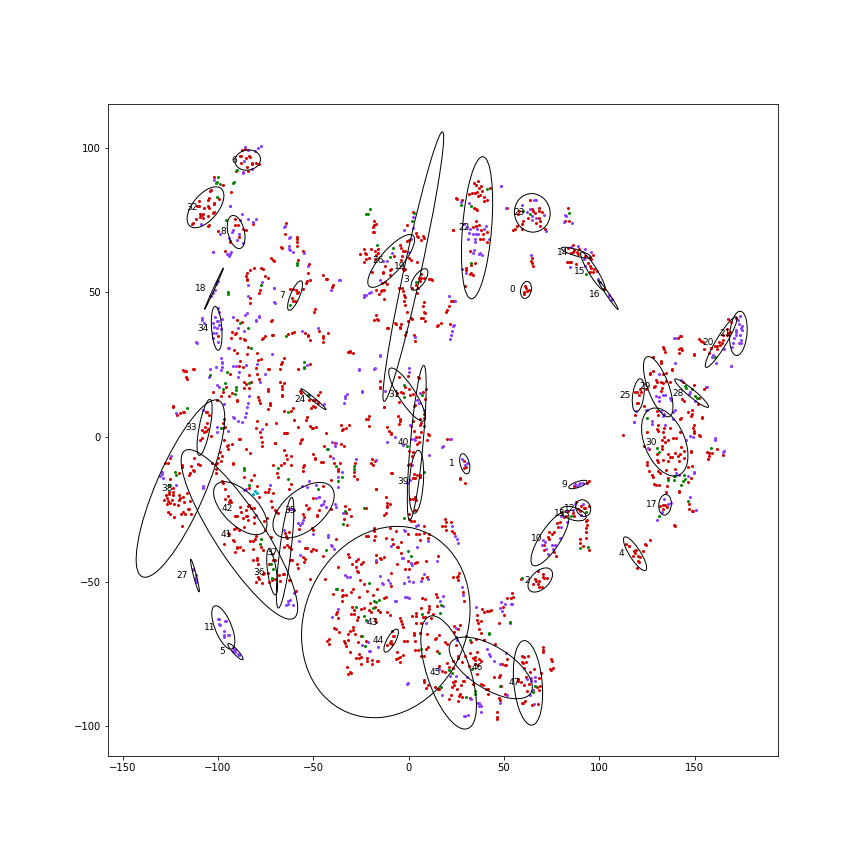

In [144]:
group = "segments" # of k-branches

%matplotlib ipympl
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    # display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
    plt.close()
    %matplotlib inline
    view_material_function(closest)
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df, group, ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# Output table of all clusters with exemplar mat formulae

In [32]:
from pandas.plotting import table

In [33]:
sorted_cluster_df = df[df.labels!=-1].sort_values(by=['labels','member_strength'], ascending=[True, False])

In [34]:
len(sorted_cluster_df)

347

In [35]:
N_clusters = len(np.unique(clusterer.labels_))-1
print(N_clusters)

49


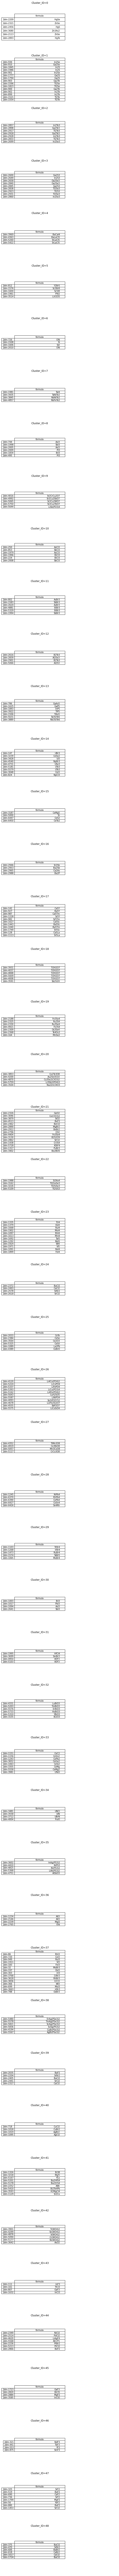

In [37]:

#N_clusters = 3
num_bands = 3
fig, axs = plt.subplots(N_clusters, 2, figsize=(8,3.5*N_clusters))

# for i in range(1,num_bands+1):
#     axs[0, i].set_title('exemplar_{0}'.format(i))

for i in range(0, N_clusters):
    #print(i)
    df_part1 = sorted_cluster_df[sorted_cluster_df.labels==i]["formula"]
    # min table size of 15
    if(len(df_part1)>=15):
        df_part1 = df_part1.head(15)
    
    axs[i, 0].set_title('Cluster_ID={0}'.format(i), y=0.95)
    axs[i, 0].axis("off")
    axs[i, 1].axis("off")

    #print(df.loc[index]["member_strength"])
    # just plot the input bands:
#     input_bands_1 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[0]}.png")
#     input_bands_2 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[1]}.png")
#     input_bands_3 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[2]}.png")

#     axs[i,1].imshow(input_bands_1, extent=[-4, 4, -4, 4], aspect=1)
#     axs[i,2].imshow(input_bands_2, extent=[-4, 4, -4, 4], aspect=1)
#     axs[i,3].imshow(input_bands_3, extent=[-4, 4, -4, 4], aspect=1)
    
    table(axs[i,0], df_part1, loc="center")  # where df is your data frame
    fig.tight_layout()
#plt.subplots_adjust(wspace=0.2)   
plt.savefig("OLD_PRINT_MCS_4_MS_3_clusters_big_table")
plt.show()

<Figure size 432x288 with 0 Axes>

# HIERARCHY dendogram

In [38]:
pip install ete3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.7 MB/s eta 0:00:0000:01:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273785 sha256=b8a67c2db1fec423ed54040546b76cb5bfd46d16eaf1b1866d0493d967936f95
  Stored in directory: /root/.cache/pip/wheels/ad/2e/cc/edcca721b423e1604c84f480a1e8e0547a223bfc068d373259
Successfully built ete3
Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install PyQt5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 38.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [63]:
from ete3 import Tree, TreeStyle
min_spanning_tree = clusterer.minimum_spanning_tree_.to_networkx()


In [64]:
ete3.__file__

NameError: name 'ete3' is not defined

In [ ]:
# Create a new ETE Tree instance
ete_tree = Tree()

# Create a dictionary to store ETE nodes for quick access
ete_nodes = {}

# Add nodes to the ETE Tree
for node in min_spanning_tree.nodes():
    ete_node = ete_tree.add_child(name=str(node))
    ete_nodes[node] = ete_node

# Add edges to the ETE Tree
for edge in min_spanning_tree.edges():
    node1, node2 = edge
    ete_node1 = ete_nodes[node1]
    ete_node2 = ete_nodes[node2]
    ete_node1.add_child(ete_node2)

# Render the tree
ete_tree.render("tree.png")

In [1]:
min_spanning_tree = clusterer.minimum_spanning_tree_.to_networkx()

ete_tree = Tree()

# Create a dictionary to store ETE nodes for quick access
ete_nodes = {}

# Add nodes to the ETE Tree
for node in min_spanning_tree.nodes():
    ete_node = ete_tree.add_child(name=str(node))
    ete_nodes[node] = ete_node

# Add edges to the ETE Tree
for edge in min_spanning_tree.edges():
    node1, node2 = edge
    ete_node1 = ete_nodes[node1]
    ete_node2 = ete_nodes[node2]
    ete_node1.add_child(ete_node2)

# Render the tree
ts = TreeStyle()
ts.mode = "c"  # Circular layout
ts.show_leaf_name = True
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180

#ete_tree.render("tree.png", tree_style=ts)




NameError: name 'clusterer' is not defined

# 2D HISTOGRAM FOR HDBSCAN PARAMETER OPTIMISATION

In [39]:
MS_vals = np.arange(2,12,1)
MCS_vals = np.arange(2,12,1)

DBCV_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_cluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_uncluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))

for i,MS in enumerate(MS_vals):
    for j,MCS in enumerate(MCS_vals):
        #print(MS,MCS)
        #print(i,j)
        clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                                gen_min_span_tree=True, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=MCS, min_samples=MS, p=0.2)
        #clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
        clusterer.fit(df[fingerprint_cols])

        df["labels"] = clusterer.labels_
        
        DBCV_vals[-(j+1),i] = clusterer.relative_validity_ 
        N_cluster_vals[-(j+1),i] = len(np.unique(clusterer.labels_))-1
        N_uncluster_vals[-(j+1),i] = len(df[df["labels"]==-1])

        

Text(0.5, 1.0, '[[0.07408321 0.05719583 0.02683594 0.02088851 0.0214418  0.01430383\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.0721241  0.05719583 0.03163518 0.02551871 0.0214418  0.02067047\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.07654506 0.06111259 0.03566593 0.02551871 0.0312092  0.02067047\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.07786822 0.06488722 0.03944247 0.03656153 0.03492427 0.02422886\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.09179331 0.07460552 0.04893343 0.03985142 0.03820086 0.03080423\n  0.01911904 0.01781102 0.01064017 0.00635515]\n [0.0778927  0.09393872 0.0545307  0.03516922 0.04101874 0.0363882\n  0.03163183 0.0206466  0.01636958 0.01439212]\n [0.08311159 0.06688069 0.05916007 0.04210127 0.04101874 0.0363882\n  0.03395227 0.02295781 0.02162625 0.01697509]\n [0.07766967 0.07191693 0.05731166 0.04578998 0.04101874 0.0363882\n  0.03395227 0.0266888  0.02162625 0.0206336 ]\n [0.13138373 0.075194   0.06322128 0.0468562  0.046

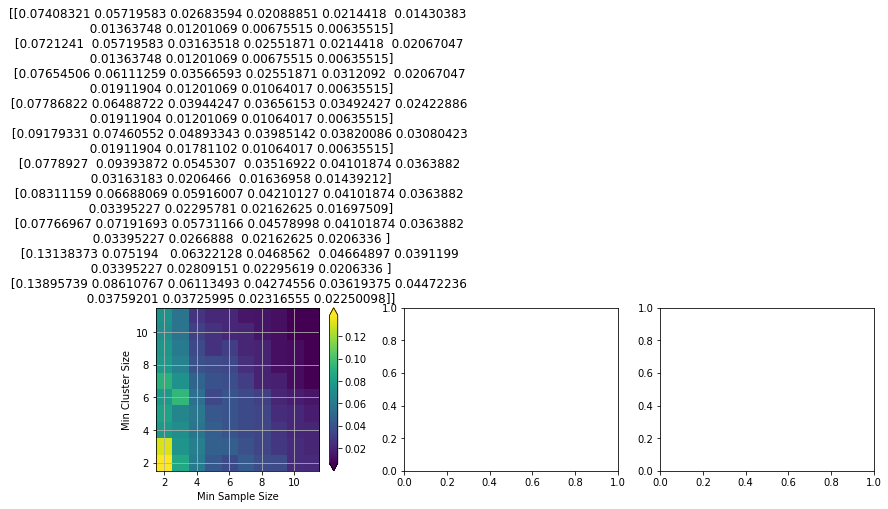

In [55]:
parameter_mesh = np.meshgrid(MS_vals, MCS_vals)
#plt.contourf(MS_vals,MCS_vals,DBCV_vals,5)
#plt.show()
#plt.imshow(DBCV_vals, extent=[2,12,2,12])
names = [DBCV_vals, N_cluster_vals, N_uncluster_vals]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

D = ax1.imshow(name, extent=[1.5,11.5,1.5,11.5])
fig.colorbar(D, ax=ax1, extend='both')

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")

ax1.grid()
ax1.set_title("{0}".format(name))
#plt.show()

#plt.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(DBCV_vals, interpolation='bilinear')

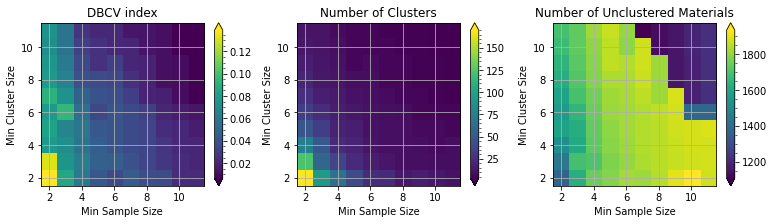

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)


# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow
pos = ax1.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar3 = fig.colorbar(pos, ax=ax1, extend='both')

# repeat everything above for the negative data
# you can specify location, anchor and shrink the colorbar
neg = ax2.imshow(N_cluster_vals, extent=[1.5,11.5,1.5,11.5])
cbar2 = fig.colorbar(neg, ax=ax2, extend='both')



# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = ax3.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar1 = fig.colorbar(pos_neg_clipped, ax=ax3, extend='both')
cbar1.minorticks_on()
cbar2.minorticks_on()
cbar3.minorticks_on()

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")
ax1.grid()
ax1.set_title("DBCV index")

ax2.set_xlabel("Min Sample Size")
ax2.set_ylabel("Min Cluster Size")
ax2.grid()
ax2.set_title("Number of Clusters")

ax3.set_xlabel("Min Sample Size")
ax3.set_ylabel("Min Cluster Size")
ax3.grid()
ax3.set_title("Number of Unclustered Materials")

plt.savefig("2d_hist_hdbscan_params", dpi=100, bbox_inches="tight")
plt.show()
